In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cards-image-datasetclassification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2579480%2F4532039%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240728%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240728T221538Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D149c81f9b55db14233718383ae9cbaf4c9d92a048963512c5443631ff4e996b0bd2bda53286c42f51927acfc5461a2bed005da76a79031a7b4940ba7fa4d231cce7255ccaa592edbbe5c71cfbfbd6cf04f9280415f5709cb46b75a668389499cbf477b09ceff33ceb0e1718821f7a2cf4fc8f1e282c8a72e4820fb42b0c25b3c07588fac720626c640d3293d2de77eef50f8aecf9ac5182c7495883823526827aa375129f63b5bda618c3c80bc285ee3775c52b28a57dad61fdb859aae9c6637a0acf3404a20cef42e477d92b663f7498e0592b6b8bb0dc515ed2e2e1a59cf69a8e577532396ac3948aa9ddf4235a4a69b7ca4ec452346a7dc70bf5fe7727fd7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 403866125 bytes downloaded
Downloaded and uncompressed: cards-image-datasetclassification
Data source import complete.


# Train Your Very First Pytorch Model!


Let's learn through doing.

In this notebook we will create an image classifier to detect playing cards.

We will tackle this problem in 3 parts:
1. Pytorch Dataset
2. Pytorch Model
3. Pytorch Training Loop

Almost every pytorch model training pipeline meets this paradigm.

In [ ]:
! pip install timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
# The timm library stands for "PyTorch Image Models." It is a popular library in the PyTorch ecosystem that provides a collection of pre-trained image models, utilities, and tools for image classification, segmentation, and other image-based tasks.
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
# The tqdm library in Python is used to display progress bars for loops, making it easier to monitor the progress of long-running tasks.
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 3.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

# Step 1. Pytorch Dataset (and Dataloader)

Would you learn how to bake a cake without first having the ingredients? No.

The same thing can be said for training a pytorch model without first having the dataset setup correctly.

This is why datasets are important:
- It's an organized way to structure how the data and labels are loaded into the model.
- We can then wrap the dataset in a dataloader and pytorch will handle batching the shuffling the data for us when training the model!

In [ ]:
# Since this class extend the Dataset class it is required to have init constructor, len function and getitem.

class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

## Create Test Dataset

In [ ]:
dataset = PlayingCardDataset(
    data_dir='/kaggle/input/cards-image-datasetclassification/train'
)

In [ ]:
len(dataset)

7624

41


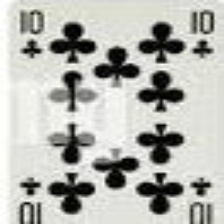

In [ ]:
image, label = dataset[6000]
print(label)
image

In [ ]:
# Get a dictionary associating target values with folder names
data_dir = '/kaggle/input/cards-image-datasetclassification/train'
# This code effectively reverses the class_to_idx mapping provided by the ImageFolder. This can be useful when you need to convert a class index back to the class name, such as for displaying results or debugging.
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [ ]:
# Taking a image to change it to 128*128 and change it to PyTorch Tensor
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
data_dir = '/kaggle/input/cards-image-datasetclassification/train'
dataset = PlayingCardDataset(data_dir, transform)

In [ ]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [ ]:
# iterate over dataset
# dataset is iterable so we can iterate through to see the image dataset
for image, label in dataset:
    break

## Dataloaders

- Batching our dataset
- It's faster to train the model in batches instead of one at a time.

In [ ]:
# There are a lot of parameter we can set but the main one are batch_size and shuffle
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
for images, labels in dataloader:
    break

In [ ]:
# The image shape become (32,2,128,128) the first parameter indicated that the batch size.
# The labels shape also become 32 since there are 32 images in one iteration so we need 32 labels.
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [ ]:
# When we rerun the for loop the labels will be different since we turn on the shuffle
labels

tensor([14, 35, 13, 12, 28, 19, 13, 25, 11, 30, 29, 48, 48,  5, 44,  4, 42, 16,
        41, 51, 27, 36, 29,  3, 15, 21,  5, 14, 29, 26, 29,  4])

# Step 2. Pytorch Model

Pytorch datasets have a structured way of organizing your data, pytorch models follow a similar paradigm.
- We could create the model from scratch defining each layer.
- However for tasks like image classification, many of the state of the art architectures are readily available and we can import them from packages like timm.
- Understanding the pytorch model is all about understanding the shape the data is at each layer, and the main one we need to modify for a task is the final layer. Here we have 53 targets, so we will modify the last layer for this.


In [ ]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        # Where we define all the parts of the model
        # This layer output 1280 classes
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        # Remove the last layer from the pretrain model
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        # Make the final classes to 53 classes
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output


In [ ]:
# Extend the nn.Module allow us to have many more functionality for the class.
# In this example if we did not extend the nn.Module the str(model) will be printed very ugly
model = SimpleCardClassifer(num_classes=53)
print(str(model)[:500])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


In [ ]:
example_out = model(images)
print(example_out)
example_out.shape # [batch_size, num_classes]

tensor([[ 0.4901, -0.3884, -0.0459,  ..., -0.2836, -0.6115, -0.0669],
        [ 0.0849,  0.0986, -0.3628,  ..., -0.1191, -0.5397, -0.1408],
        [-0.0499,  0.1255, -0.1542,  ..., -0.1347, -0.0430,  0.1300],
        ...,
        [ 0.1730,  0.4079,  0.0602,  ..., -0.2630,  0.0542,  0.1977],
        [ 0.4621, -0.1924,  0.1067,  ...,  0.0180, -0.1851,  0.0031],
        [-0.1565, -0.0313, -0.0501,  ..., -0.1228, -0.1769,  0.0362]],
       grad_fn=<AddmmBackward0>)


torch.Size([32, 53])

# Step 3. The training loop

- Now that we understand the general paradigm of pytorch datasets and models, we need to create the process of training this model.
- Some things to consider: We want to validate our model on data it has not been trained on, so usually we split our data into a train and validate datasets (I have whole videos on this). This is easy because we can just create two datasets using our existing class.
    - Terms:
        - Epoch: One run through the entire training dataset.
        - Step: One batch of data as defined in our dataloader
- This loop is one you will become familiar with when training models, you load in data to the model in batches - then calculate the loss and perform backpropagation. There are packages that package this for you, but it's good to have at least written it once to understand how it works.
- Two things to select:
    - optimizer, `adam` is the best place to start for most tasks.
    - loss function: What the model will optimize for.


In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 53]) torch.Size([32])


## Setup Datasets

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '../input/cards-image-datasetclassification/train/'
valid_folder = '../input/cards-image-datasetclassification/valid/'
test_folder = '../input/cards-image-datasetclassification/test/'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

# Just need to shuffle the training set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Simple Training Loop

In [ ]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Run backpropagation one the model
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.6150075776692077, Validation loss: 0.3675780385170343


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5958137317694497, Validation loss: 0.2999835400086529


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.35846719911941577, Validation loss: 0.17657237660210087


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.2644712243616143, Validation loss: 0.12708448419031107


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.1942974710553603, Validation loss: 0.14434752464294434


# Visualize Losses

We can plot our training and validation loss through this training, usually we do this at the end of each epoch. We see that our accuracy on the validation dataset is `x`! There are a LOT more things to learn about that can drastically improve how to train a model which I will cover in future videos, but this should give you a good start!



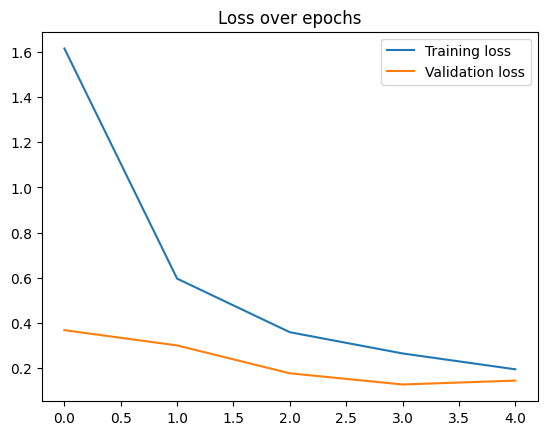

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()




# Evaluating the Results



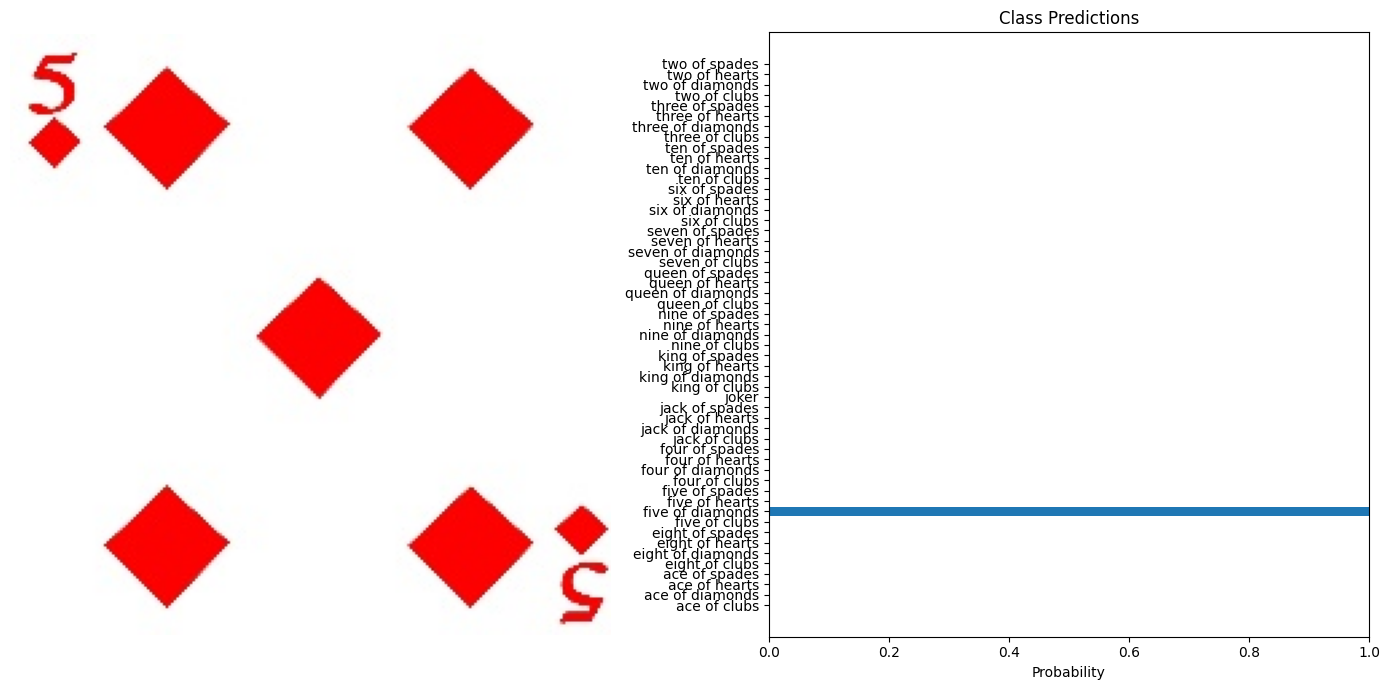

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/kaggle/input/cards-image-datasetclassification/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)

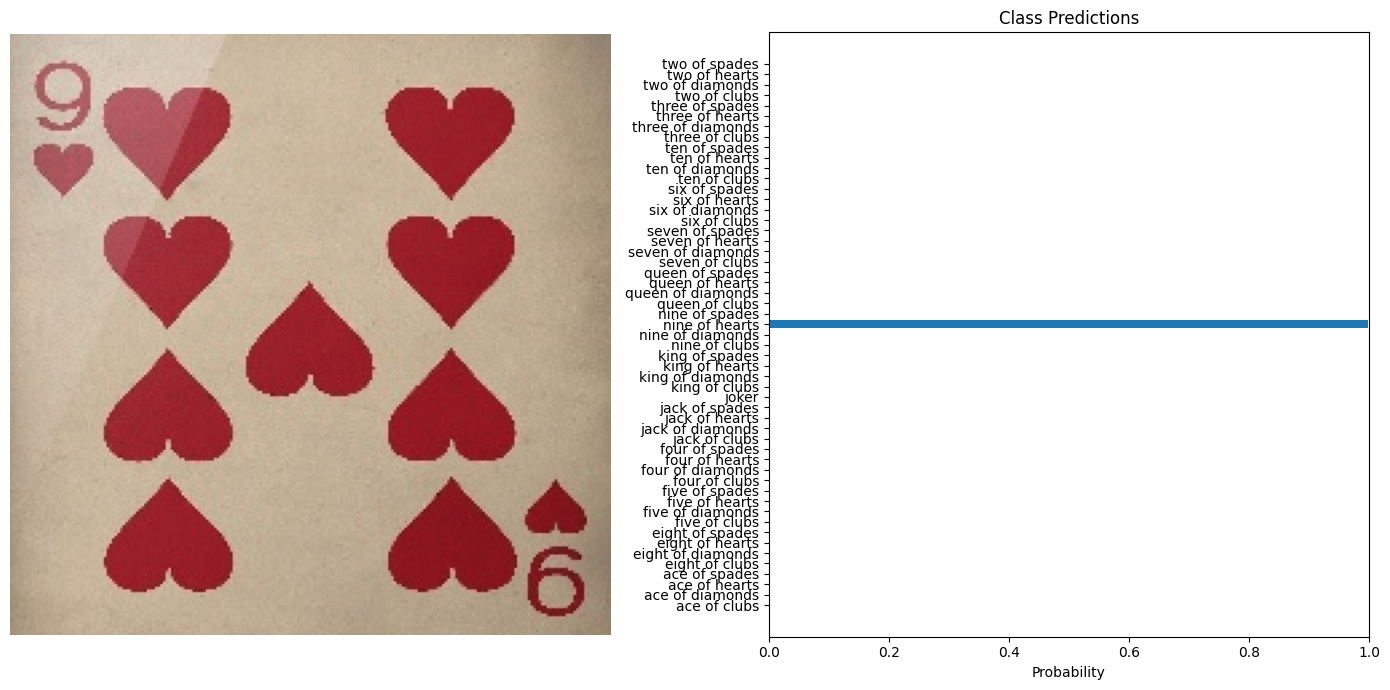

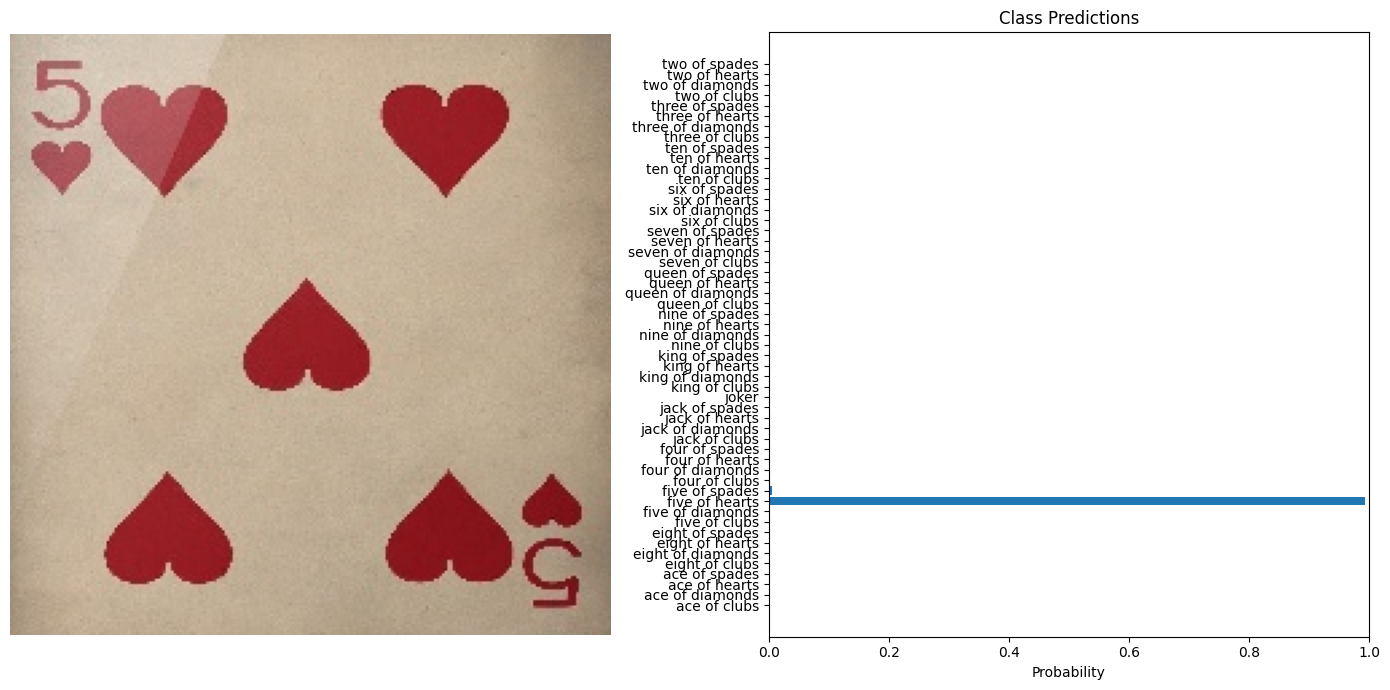

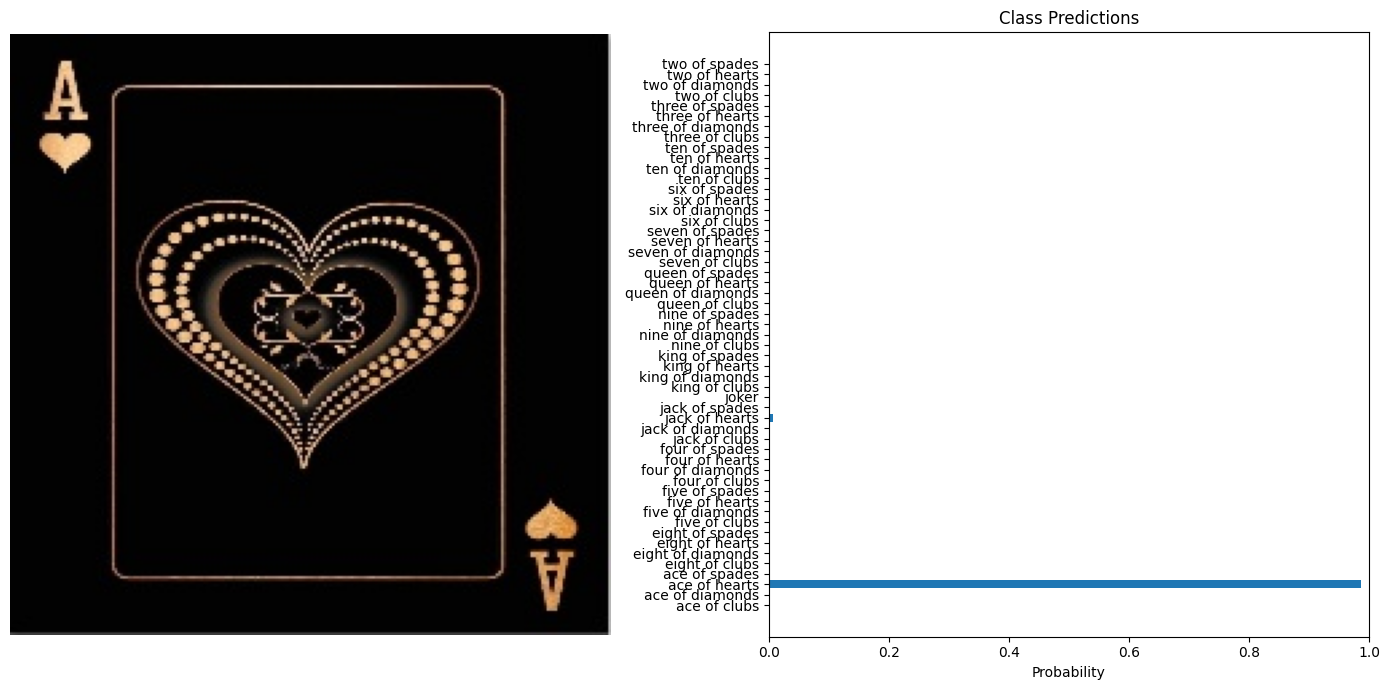

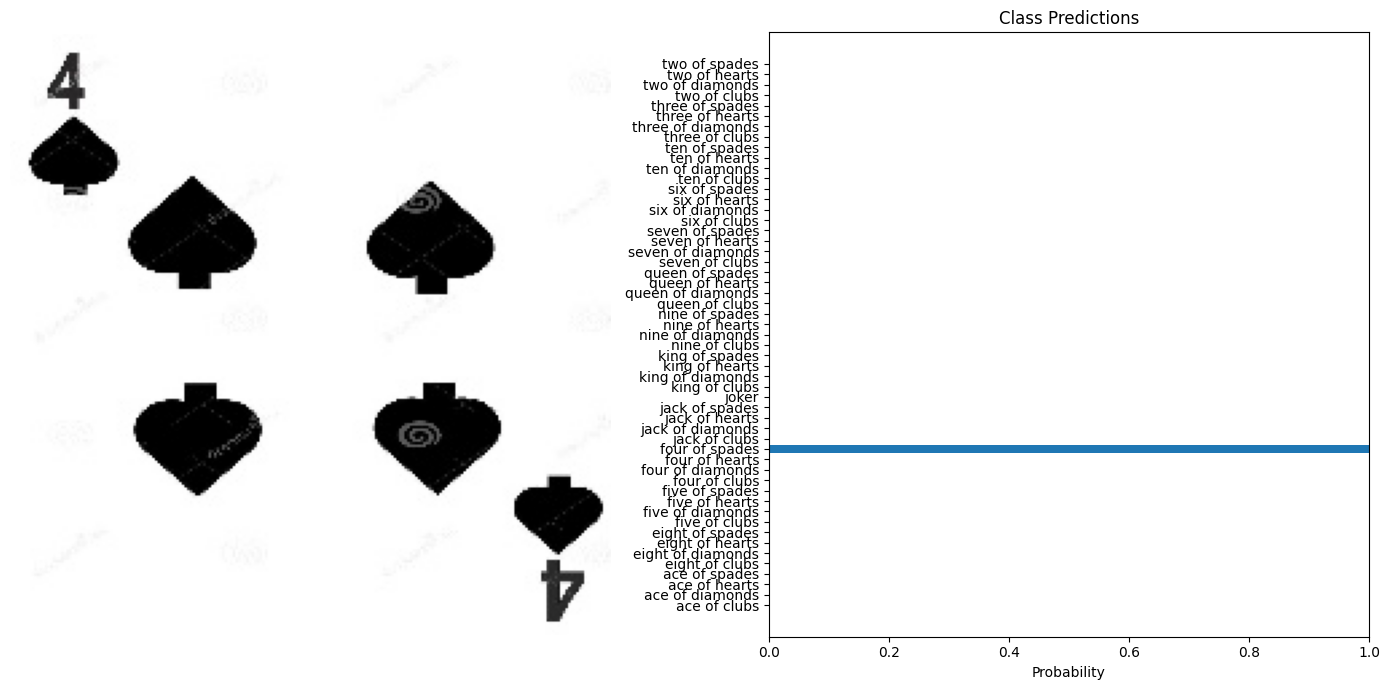

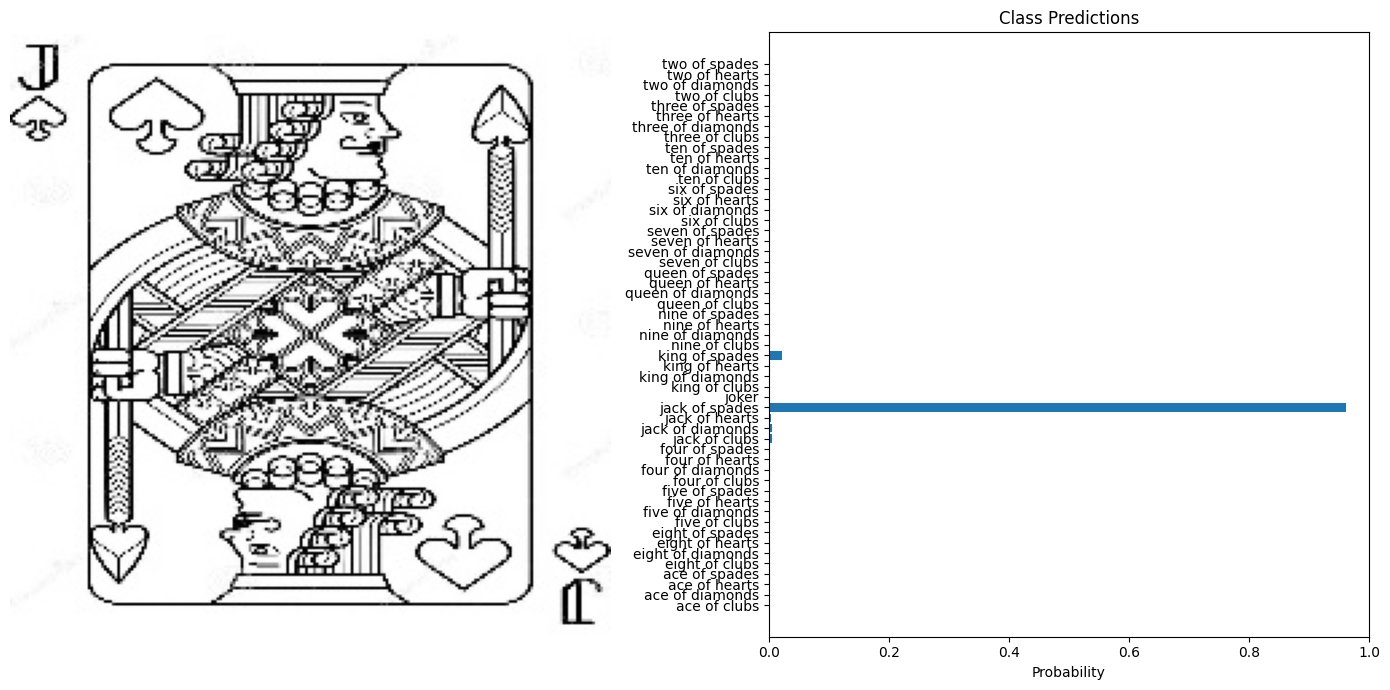

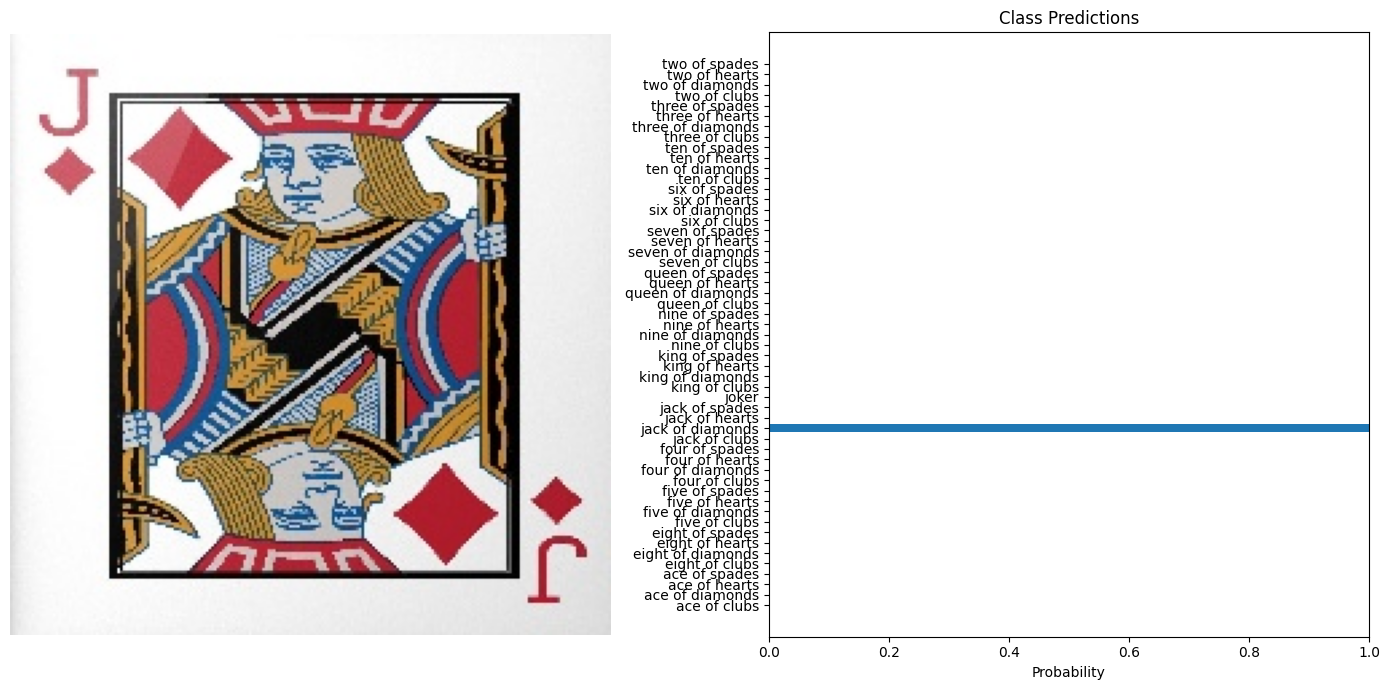

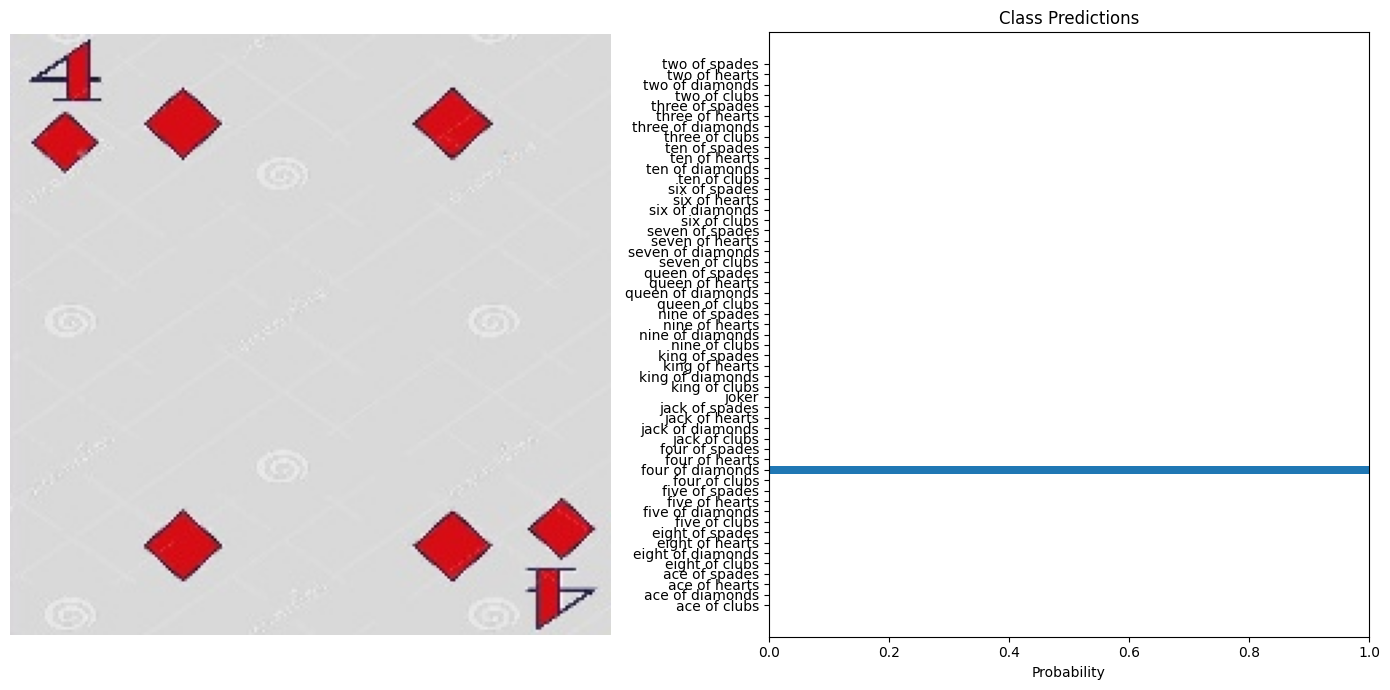

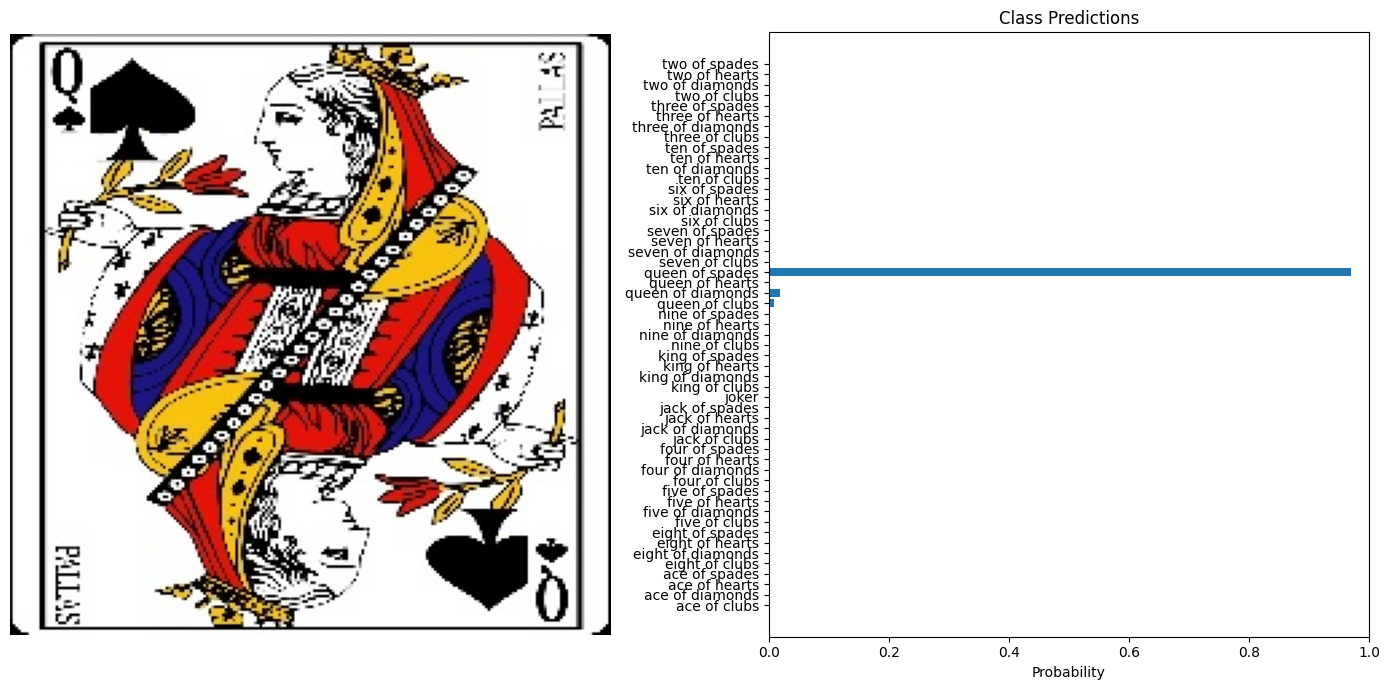

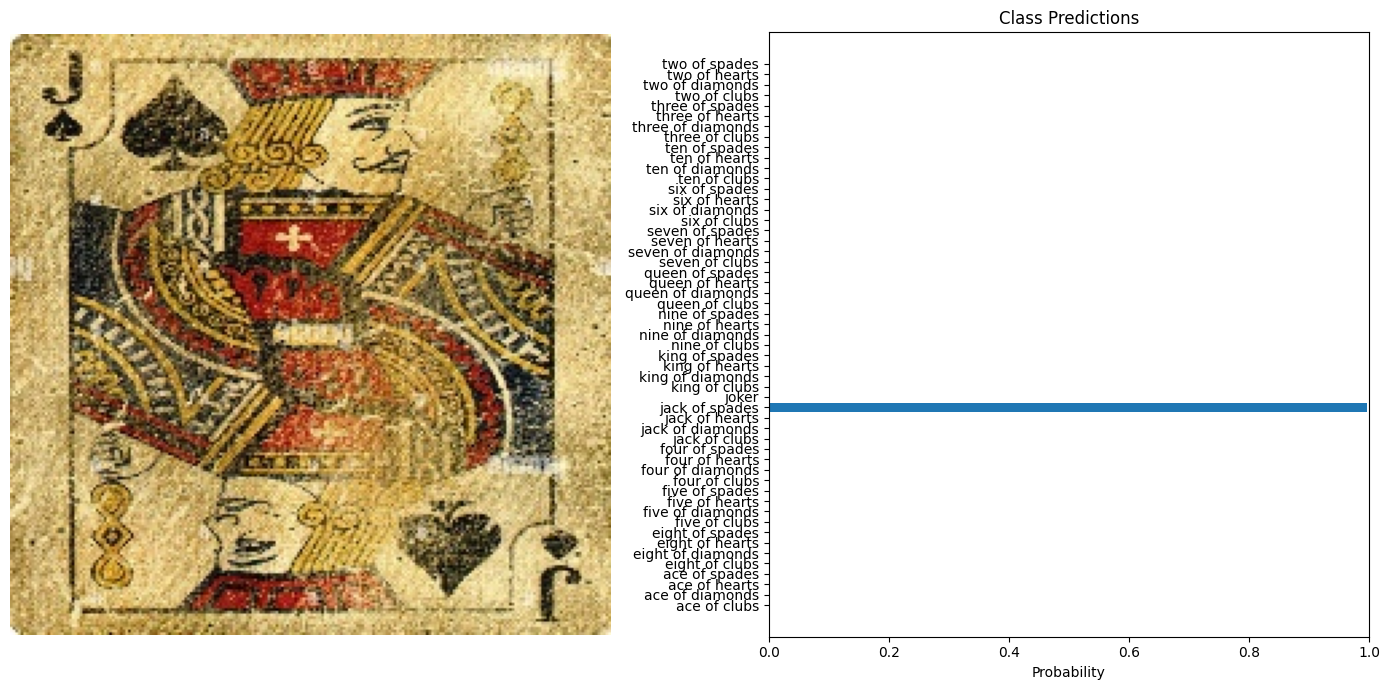

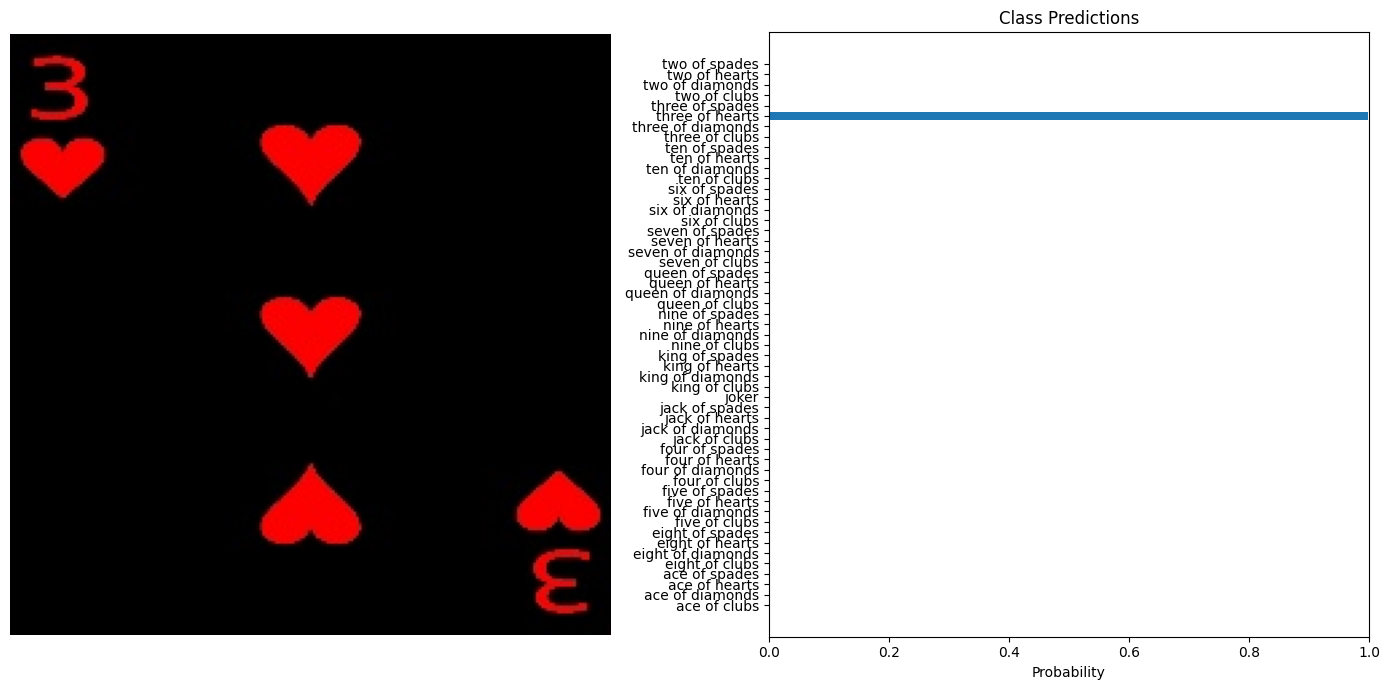

In [ ]:
from glob import glob
test_images = glob('../input/cards-image-datasetclassification/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes
    visualize_predictions(original_image, probabilities, class_names)

In [ ]:
#  Calculate the accuracy of our model on the validation and test set.
validation_accuracy = calculate_accuracy(model, validation_loader)
